In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import utm

# for widget:
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import Image
import matplotlib.image as mpimg
from matplotlib import gridspec
import json
from dataset import Drive360Loader

# Helper functions

In [67]:
xy_speed_angle(0, 0, 10, -20, 0, 1, speed_factor=1, angle_offset=0)

((9.396926207859085, -3.420201433256687), -20)

In [65]:
## HELPER FUNCTIONS TO PROJECT TRAJECTORY FROM SPEED AND STEERING WHEEL ANGLE

def xy_speed_angle(x0, y0, speed, steer_angle, previous_heading, steer_factor, speed_factor=10, angle_offset=0):
    """
    Calculate a new x,y position based on a starting position, steering wheel angle, and speed.
    
    input:
        speed_factor: ratio between distance scale of speed and of UTM coordinates,
            so that they are scaled compatibly if plotting both projected coordinated
            and UTM ground truth
    
    returns: (x, y), new_heading
    """
    # heading: clockwise from N,
    # steer angle: counterclockwise from N
    
    # TEMP clip steering angle
    steer_angle = np.clip(steer_angle, -360, 360)
    
    # NOTE: option to specify an offset, e.g. for a specific vehicle
    steer_angle -= angle_offset
    
#     n_angle = previous_heading - steer_factor * steer_angle
    
    # convert to ccw from E
#     angle = (450 - n_angle) % 360
#     angle = (450 - steer_angle) % 360
    angle=steer_angle
    next_heading=angle
    
#     if speed < 5:
#         next_heading = previous_heading
#     else:
#         next_heading = (450 - angle) % 360
    
    return (x0 + math.cos(math.radians(angle)) * speed / speed_factor,
            y0 + math.sin(math.radians(angle)) * speed / speed_factor), next_heading


def project_x_y_position(data, steering_feature='angle', speed_feature='speed', steer_factor=.01, target_suffix='', angle_offset=0):
    """
    steer_factor: scaling between steering wheel angle and car angle
    target_suffix: appends a suffix to the columns names of the new features,
        e.g. if running this for different projectiong but with a single dataframe
    """
    
    first_idx = data.index[0]
    for i, row in data.iterrows():
        if i == first_idx:
            x0 = 0
            y0 = 0
            # use ground truth heading as the starting heading,
            # for consistency with UTM positions
            previous_heading = row['hereCurrentHeading']
        (x, y), heading = xy_speed_angle(x0, y0,
                                         row[speed_feature], # ground truth or predicted canSpeed
                                         row[steering_feature], # ground truth or predicted canSteer
                                         previous_heading,
                                         steer_factor,
                                         angle_offset=angle_offset,
#                                          speed_factor=1.0 / 3600
                                        )
        # write results
        data.loc[i, 'next_x'] = x
        data.loc[i, 'next_y'] = y
        data.loc[i, 'next_heading'] = heading

        x0 = x
        y0 = y
        previous_heading = heading

    # the projected coordinates are for the next row
    data.loc[:, 'proj_x' + target_suffix] = data['next_x'].shift()
    data.loc[:, 'proj_y' + target_suffix] = data['next_y'].shift()
    data.loc[:, 'proj_heading' + target_suffix] = data['next_heading'].shift()

    # starting conditions
    data.loc[data.index[0], 'proj_x' + target_suffix] = 0
    data.loc[data.index[0], 'proj_y' + target_suffix] = 0
    data.loc[data.index[0], 'proj_heading' + target_suffix] = data.loc[data.index[0], 'hereCurrentHeading']

In [43]:
## HELPER FUNCTIONS TO GENERATE PLOTS OF TRAJECTORIES

def plot_path(data, start_idx, end_idx, x_feature, y_feature, steering_feature='angle', target_idx=None, alpha=1, ax=None, colors=['b', 'g', 'r'], color_by_turn=False, label=None):
    """
    start_idx, end_idx: indices of slice, where 0 is the first observation in the chapter
    target_idx: optional, highlight a specific position along the route with a large point, where 0 is the first obsevation in the chapter
    """
    data = data.copy()
    
    # set index from 0
    data.reset_index(drop=True, inplace=True)
    
    if start_idx is None:
        start_idx = data.iloc[0]['timestep']
    if end_idx is None:
        end_idx = data.iloc[-1]['timestep']

    data = data[data['timestep'].between(start_idx, end_idx)]

    if ax is None:
        fig, ax = plt.subplots(figsize=(25, 10))

    if color_by_turn:
        # color the route differently depending on steering direction
        pos_angle = data[data[steering_feature] > 0]
        neg_angle = data[data[steering_feature] < 0]
        no_angle = data[data[steering_feature] == 0]
        ax.scatter(pos_angle[x_feature], pos_angle[y_feature], alpha=alpha,
                   c=colors[0],
                   s=30,
                   label='right turns')
        ax.scatter(neg_angle[x_feature], neg_angle[y_feature], alpha=alpha,
                   c=colors[1],
                   s=30,
                   label='left turns')
        ax.scatter(no_angle[x_feature], no_angle[y_feature], alpha=alpha,
                   c=colors[2],
                   s=30,
                   label='straight')
    else:
        ax.scatter(data[x_feature], data[y_feature], alpha=alpha, c=colors[0], s=30, label=label if label else '')
            
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)

    if target_idx:
        # plot a dot for a specific timestep to highlight it on the map
        ax.scatter(data.loc[data['timestep'] == target_idx, x_feature], data.loc[data['timestep'] == target_idx, y_feature],
                   marker='o',
                   edgecolor='black', linewidth='3', facecolor=colors[0], alpha=0.8,
                   s=400)
        ax.annotate("t={}".format(target_idx), (data.loc[data['timestep'] == target_idx, x_feature], data.loc[data['timestep'] == target_idx, y_feature]))

    plt.gca().set_aspect('equal', adjustable='box')

    ax.set_title("Plotting by '{}' and '{}' coordinates".format(x_feature, y_feature))

    for i, idx in enumerate(data.index):
        if i % int(data.shape[0] / 10) == 0:  # freq of timesteps to label
            ax.annotate("t={}".format(idx), (data.loc[idx, x_feature], data.loc[idx, y_feature]))
            
    return ax, (data[x_feature].min(), data[x_feature].max()), (data[y_feature].min(), data[y_feature].max())


def plot_steering_wheel(ax, angle, color, title):
    """Utility to plot steering wheel angle"""
    # plot true steering angle
    theta = [0, math.radians(angle)]
    r = [0, 1]
    ax.plot(theta, r, c=color, linewidth=2)
    ax.set_title("{}: {:.2f}".format(title, angle), loc='left', pad=30)
    
    # rotation arc
    if angle < 0:
        theta = [math.radians(x) for x in np.arange(angle, 0, 1)]
        r = np.ones_like(np.arange(angle, 0, 1)) * .8
    elif angle > 0:
        theta = [math.radians(x) for x in np.arange(0, angle, 1)]
        r = np.ones_like(np.arange(0, angle, 1)) * .8
    ax.plot(theta, r, c=color)
    ax.fill_between(theta, 0, r, alpha=0.2, facecolor=color)
    
    # plot north marker and rotate to north
    ax.plot([0, 0], [0, 1], c='black', linewidth=1.2)
    ax.set_theta_zero_location('N')
    ax.set_rticks([1])  # less radial ticks
    
    return ax


def plot_all_routes(ax, data, alpha, results_to_plot, target_idx=None, include_utm_coords=False):
    # collect all bounds to make sure plot includes all data
    all_x_bounds = []
    all_y_bounds = []

    if include_utm_coords:
        ax, x_bounds, y_bounds = plot_path(data, None, None,
                                           x_feature='easting_0',
                                           y_feature='northing_0',
                                           steering_feature='true_steer',
                                           alpha=alpha,
                                           ax=ax,
                                           colors=['gray']*3,
                                           target_idx=target_idx,
                                           label='True utm coordinates')
        all_x_bounds.append(x_bounds)
        all_y_bounds.append(y_bounds)

    # plot projections of ground truth steering angle and speed
    ax, x_bounds, y_bounds = plot_path(data, None, None,
                                       x_feature='proj_x_true',
                                       y_feature='proj_y_true',
                                       steering_feature='true_steer',
                                       alpha=alpha,
                                       ax=ax,
                                       colors=['g']*3,
                                       target_idx=target_idx,
                                       label='Projected from TRUE steering & speed')
    all_x_bounds.append(x_bounds)
    all_y_bounds.append(y_bounds)

    # plot projections of predicted steering angle and speed
    for _, label, color in results_to_plot:
        ax, x_bounds, y_bounds = plot_path(data, None, None,
                                           x_feature='proj_x_pred_{}'.format(label),
                                           y_feature='proj_y_pred_{}'.format(label),
                                           steering_feature='pred_steer_{}'.format(label),
                                           alpha=alpha, ax=ax,
                                           colors=[color]*3,
                                           target_idx=target_idx,
                                           label='Projected from {} PRED steering & speed'.format(label.upper()))
        all_x_bounds.append(x_bounds)
        all_y_bounds.append(y_bounds)

    for i, bounds in enumerate(zip(*all_x_bounds)):
        if i == 0:
            x_min = min(bounds)
        else:
            x_max = max(bounds)

    for i, bounds in enumerate(zip(*all_y_bounds)):
        if i == 0:
            y_min = min(bounds)
        else:
            y_max = max(bounds)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)

    leg = ax.legend(loc='best')
    for lh in leg.legendHandles: 
        lh.set_alpha(.8)

    ax.set_title("Chapter: " + data.iloc[0]['chapter'])
    
    return ax

# Load data

In [44]:
config = json.load(open('./config - load test data 2020-04-22.json'))

test_loader = Drive360Loader(config, 'test')

df = test_loader.drive360.dataframe.loc[test_loader.drive360.indices]
df.reset_index(inplace=True, drop=True)

results_to_plot = [
    ('resnet34.csv', 'resnet', 'red'),
    ('resnext101_32x4d_ssl.csv', 'ssl', 'blue'),
    ('resnext101_32x4d_swsl.csv', 'swsl', 'orange'),
    ('simclr.csv', 'simclr', 'violet')
]

for results, label, _ in results_to_plot:
    pred = pd.read_csv('evaluate_model_all_bottom_frozen/results/' + results)
    df['pred_speed_{}'.format(label)] = pred['canSpeed']
    df['pred_steer_{}'.format(label)] = pred['canSteering']

df.rename(columns={
    'canSpeed': 'true_speed',
    'canSteering': 'true_steer'
}, inplace=True)


# Note: chapter 87_train has significant null values for GPS data, so may be better to choose
# other chapters for route plotting
# (also 328_train has one null value, so should either skip or interpolate that value)
df = df[~df.chapter.isin(['87_train', '328_train'])].reset_index(drop=True)


# calculate UTM coordinates
z = df.apply(lambda row: utm.from_latlon(row['hereMmLatitude'], row['hereMmLongitude']), axis=1)
df[['easting', 'northing', 'zone_num', 'zone_let']] = pd.DataFrame(z.tolist(), index=df.index)

del pred
del test_loader
del z

df.chapter.unique()

Loading data from ./Drive360Images_160_90/drive360challenge_split_test_stratify.csv...
Phase: test # of data: 136080


array(['0_train', '101_train', '158_train', '15_validation', '181_train',
       '189_train', '18_train', '194_train', '19_train', '207_train',
       '208_train', '216_train', '247_train', '254_train', '261_train',
       '269_train', '273_train', '278_train', '288_train', '291_train',
       '2_train', '2_validation', '308_train', '322_train',
       '32_validation', '337_train', '340_train', '344_train', '34_train',
       '374_train', '423_train', '427_train', '456_train', '469_train',
       '472_train', '492_train', '495_train', '508_train', '510_train',
       '519_train', '568_train', '570_train', '58_train', '68_train'],
      dtype=object)

# Prepare data for one chapter

In [45]:
def project_x_y_for_dataset(df, chapter, steer_factor=.01, angle_offset=0, i_min=None, i_max=None):
    """
    Calculate the x,y positions for a chapter, projected based on steering and angle.
    Optionally specify of range of indices for iloc.
    At the first timestep (either 0 or based on the i_min if given),
    then the x,y positions and starting heading are synced for all routes at that point.
    """
    data = df.loc[df.chapter == chapter, :].copy()

    ## ? Should we shift the steering/speed to the timestep when it happened,
    # or keep it at the timestep when it was predicted? (predict 1s in the future)
    data['true_steer'] = data['true_steer'].shift(10)
    data['true_speed'] = data['true_speed'].shift(10)
    for _, label, _ in results_to_plot:
        data['pred_speed_{}'.format(label)] = data['pred_speed_{}'.format(label)].shift(10)
        data['pred_steer_{}'.format(label)] = data['pred_steer_{}'.format(label)].shift(10)
    data = data[data.true_steer.notnull()]  # after shift, drop rows without data

    # zero index for this chapter
    # (starting after any rows that were dropped because of the shift)
    data.reset_index(drop=True, inplace=True)
    
    # preserve original timestamp indices for reference
    data = data.reset_index().rename(columns={'index': 'timestep'})
    
    # index as specified by i_min and i_max
    data = data.iloc[i_min:i_max]

    data['easting_0'] = data['easting'] - data.iloc[0]['easting']
    data['northing_0'] = data['northing'] - data.iloc[0]['northing']
    
    # project x,y positions from speed and steering angle
    project_x_y_position(data,
                         steering_feature='true_steer', speed_feature='true_speed', steer_factor=steer_factor,
                         target_suffix='_true',
                         angle_offset=angle_offset)

    for _, label, _ in results_to_plot:
        project_x_y_position(data,
                             steering_feature='pred_steer_{}'.format(label),
                             speed_feature='pred_speed_{}'.format(label),
                             steer_factor=steer_factor,
                             target_suffix='_pred_{}'.format(label),
                             angle_offset=angle_offset)
    return data

# Static plot of the entire trajectory

In [ ]:
# 2_train is a good route with many turns

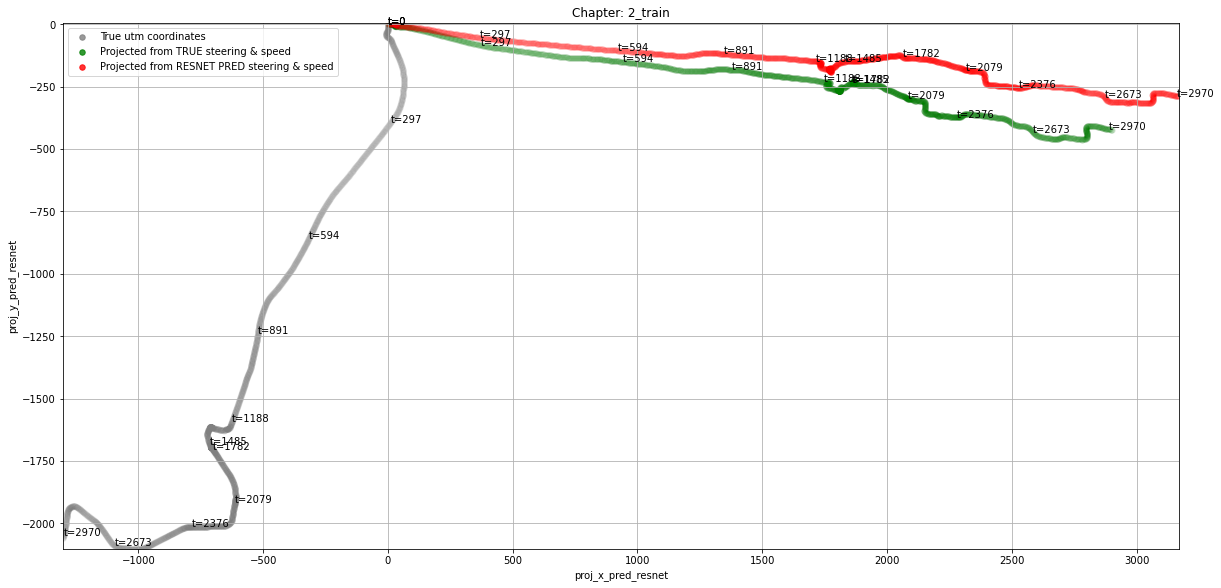

In [66]:
data = project_x_y_for_dataset(df,
                               chapter='2_train',
                               steer_factor=1)

fig, ax = plt.subplots(figsize=(20, 10))
alpha = .05

plot_all_routes(ax, data, alpha, results_to_plot=results_to_plot[:1], target_idx=None, include_utm_coords=True)

# Widget to follow the trajectory

In [75]:
from PIL import Image

In [136]:
def show_image(i, data, alpha=0.01, include_utm_coords=False, height=8):
    """
    i: display image and mark plot at this timestep (zeroed to the beginning of the chapter -- not necesasrily the 'data' input)
    """
    
    # color for ground truth datapoints
    true_color = 'g'

    # set up figure
    fig = plt.figure(figsize=(20, height))
    spec = gridspec.GridSpec(ncols=2 + len(results_to_plot),
                             nrows=2, figure=fig, height_ratios=[1, 2], width_ratios=[3] + [1] * (1 + len(results_to_plot)))
    ax_0 = fig.add_subplot(spec[0, 0])
    ax_1 = fig.add_subplot(spec[0, 1], projection='polar')
#     ax_2 = fig.add_subplot(spec[1, :])
    steering_axes = []
    for j, (_, label, _) in enumerate(results_to_plot):
        steering_axes.append(fig.add_subplot(spec[0, 2 + j], projection='polar'))
    
    # plot steering angles
    plot_steering_wheel(ax=ax_1,
                        angle=data.loc[i, 'true_steer'],
                        color=true_color,
                        title="True Steer Angle")
    
    for j, (_, label, color) in enumerate(results_to_plot):
        plot_steering_wheel(ax=steering_axes[j],
                            angle=data.loc[i, 'pred_steer_{}'.format(label)],
                            color=color,
                            title="{} Steer Angle".format(label.upper()))
    
    # plot image
    img = Image.open("Drive360Images_160_90/" + data.loc[i, 'cameraFront']).resize((160, 90))
    ax_0.imshow(img)
    ax_0.set_title("Frame {}".format(i))
    
#     # plot x,y coords
#     plot_all_routes(ax=ax_2,
#                     data=data,
#                     alpha=alpha,
#                     results_to_plot=results_to_plot,
#                     target_idx=i,
#                     include_utm_coords=include_utm_coords)

    plt.tight_layout()
    plt.show()

In [ ]:
# 194_train
# 322_train around 2019

In [137]:
# Index of timestamps to include (0 = beginning of chapter).
# Can be set to None to not specify
SYNC_FROM_TIMESTAMP = None  # all routes are synced from this timestep
LAST_TIMESTAMP = None
    
SKIP = 1  # Increments for the slider. Each timestep = 1/10s
ALPHA = 0.01  # for opacity of the lines
INCLUDE_UTM = False  # whether to additionally plot the UTM coordinates
FIG_HEIGHT = 15

data = project_x_y_for_dataset(df,
                               chapter='423_train',
                               i_min=SYNC_FROM_TIMESTAMP,
                               i_max=LAST_TIMESTAMP,
                               steer_factor=0.005)

# print error for each model, as reference
for _, label, _ in results_to_plot:
    print("Model:", label)
    print("Steer angle MSE:", np.mean(np.square(data['true_steer'] - data['pred_steer_{}'.format(label)])))
    print("Speed MSE:", np.mean(np.square(data['true_speed'] - data['pred_speed_{}'.format(label)])))
    print()

widgets.interact(show_image,
                 i=widgets.IntSlider(min=SYNC_FROM_TIMESTAMP if SYNC_FROM_TIMESTAMP is not None else data.iloc[0]['timestep'],
                                     max=LAST_TIMESTAMP if LAST_TIMESTAMP is not None else data.iloc[-1]['timestep'],
                                     step=SKIP,
                                     layout=Layout(width='50%'),
                                     continuous_update=False,
                                     description="1/10s: "),
                 alpha=widgets.fixed(ALPHA),
                 include_utm_coords=widgets.fixed(INCLUDE_UTM),
                 height=widgets.fixed(FIG_HEIGHT),
                 data=widgets.fixed(data))

Model: resnet
Steer angle MSE: 1536.2351332792252
Speed MSE: 9.697776554249854

Model: ssl
Steer angle MSE: 2202.6822224995485
Speed MSE: 9.023473809920823

Model: swsl
Steer angle MSE: 2711.2052318079805
Speed MSE: 8.976674652457074

Model: simclr
Steer angle MSE: 1244.1857814410475
Speed MSE: 9.776328312184436



interactive(children=(IntSlider(value=0, continuous_update=False, description='1/10s: ', layout=Layout(width='…

<function __main__.show_image(i, data, alpha=0.01, include_utm_coords=False, height=8)>

Text(0.5, 1.0, 'Speed for a Segment of a Chapter')

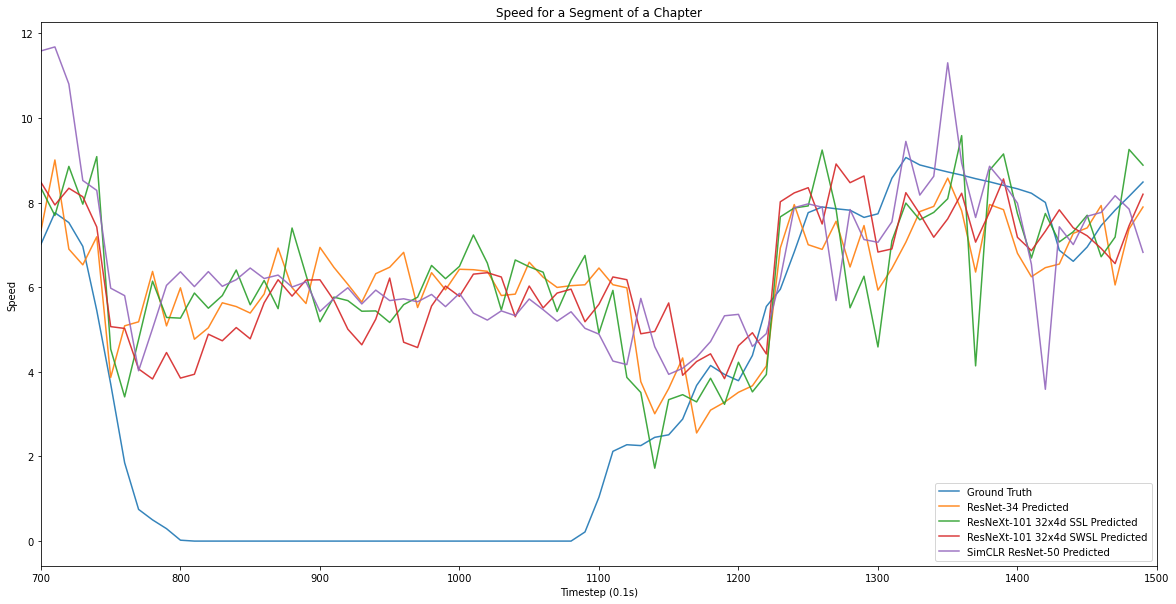

In [157]:
fig, ax = plt.subplots()
d = data[[c for c in data.columns if 'speed' in c]].iloc[700:1500:10]
d.columns = ['Ground Truth',
             'ResNet-34 Predicted',
             'ResNeXt-101 32x4d SSL Predicted',
             'ResNeXt-101 32x4d SWSL Predicted',
             'SimCLR ResNet-50 Predicted'
            ]
ax = d.plot.line(figsize=(20, 10), ax=ax, alpha=0.9)
ax.set_xlabel('Timestep (0.1s)')
ax.set_ylabel('Speed')
ax.set_xlim(700, 1500)
ax.set_title('Speed for a Segment of a Chapter')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

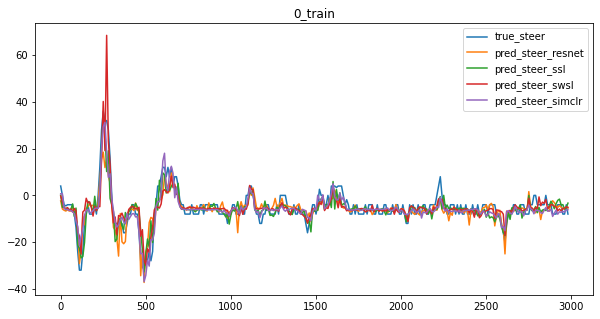

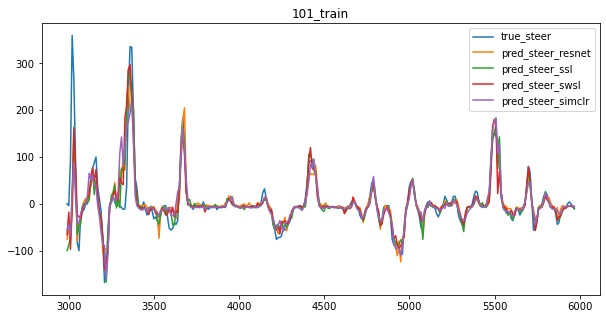

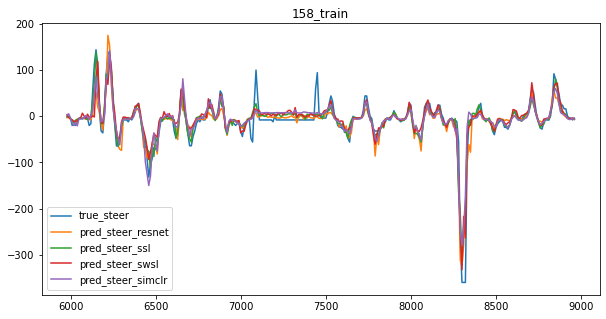

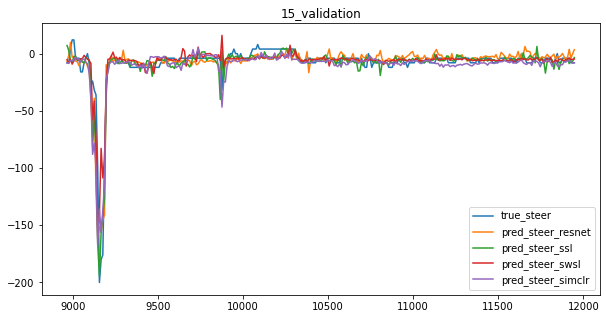

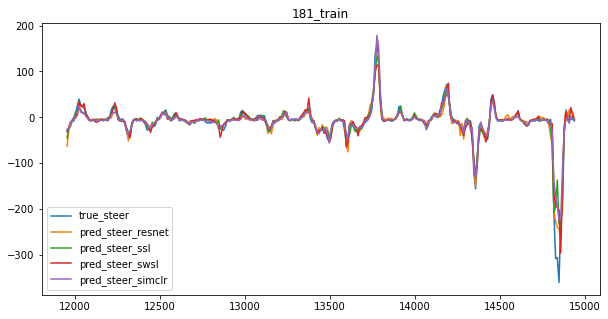

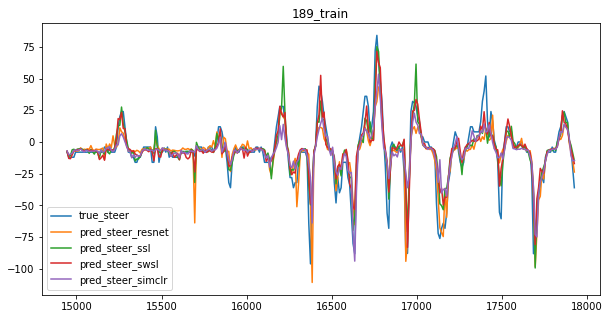

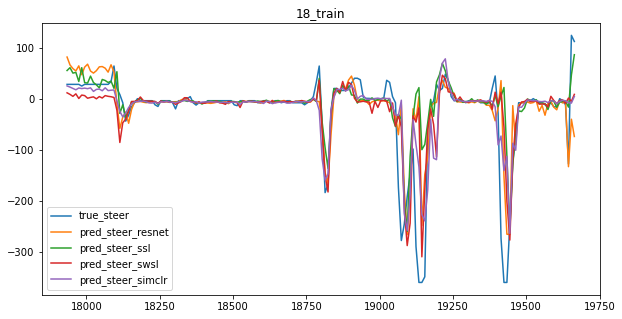

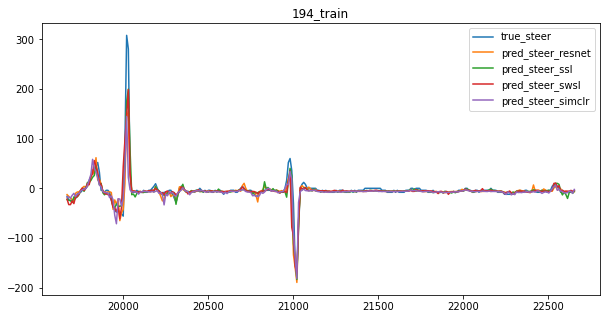

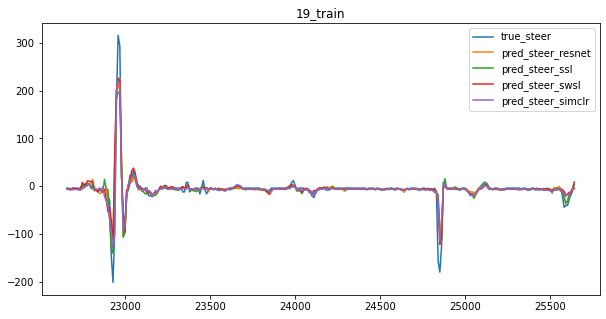

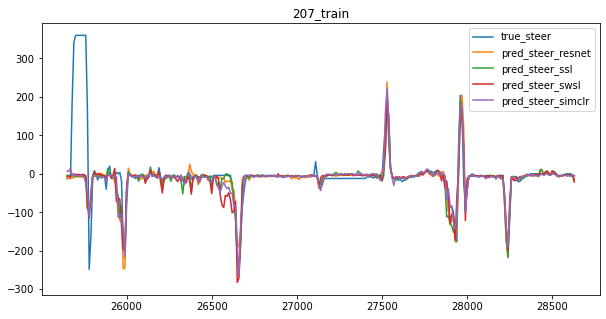

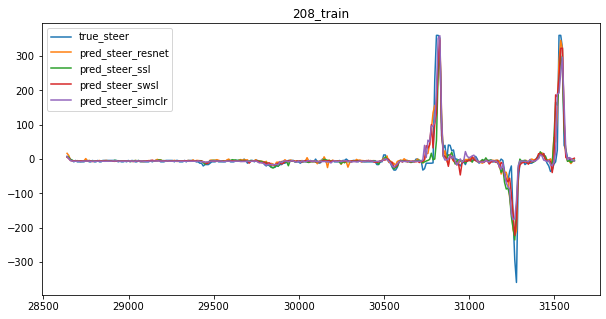

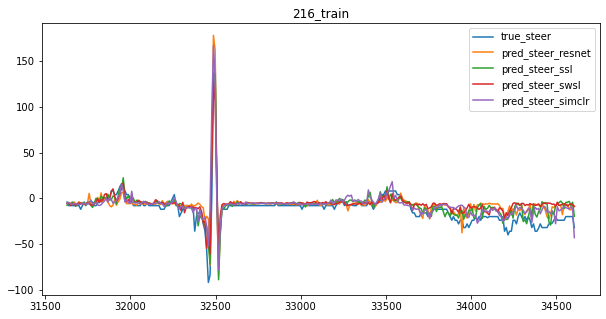

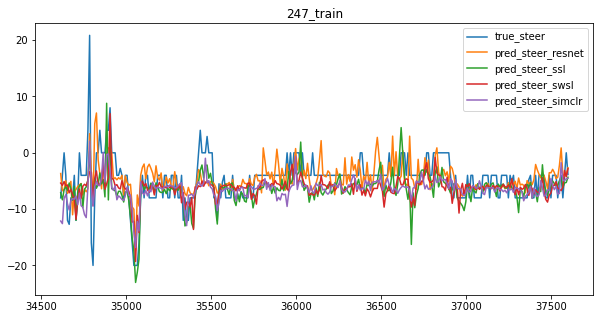

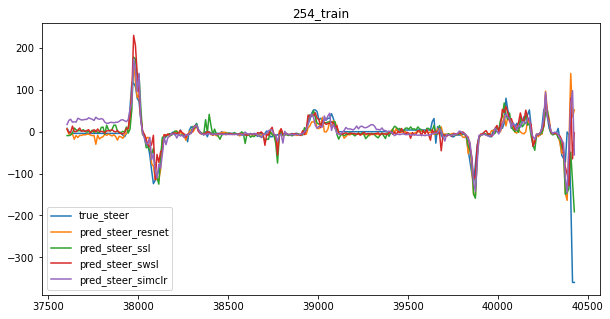

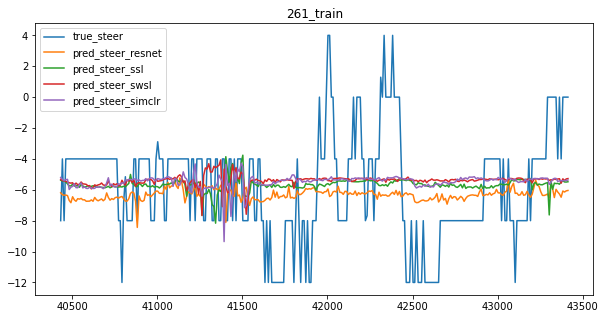

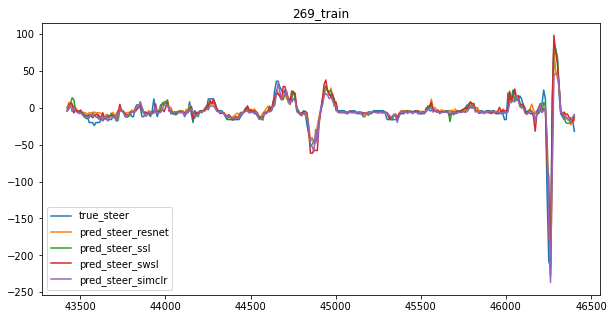

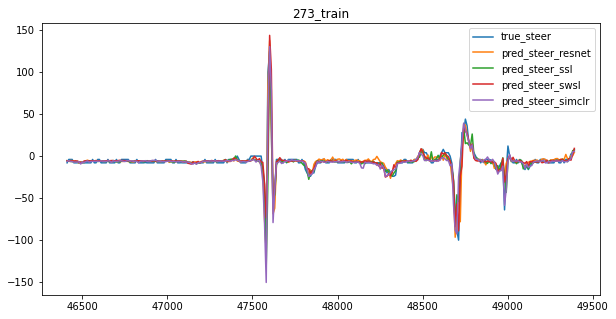

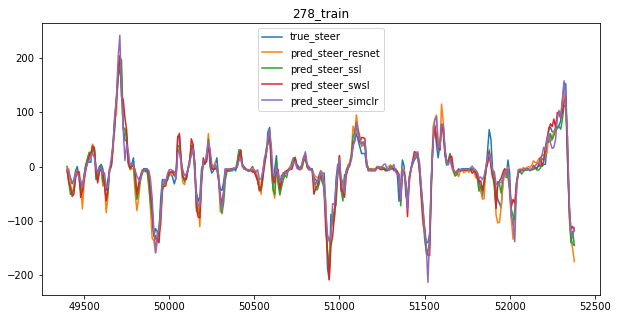

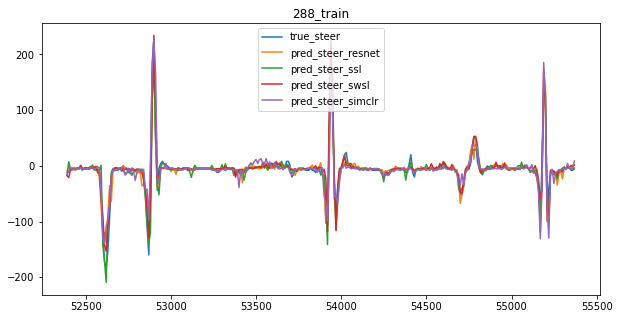

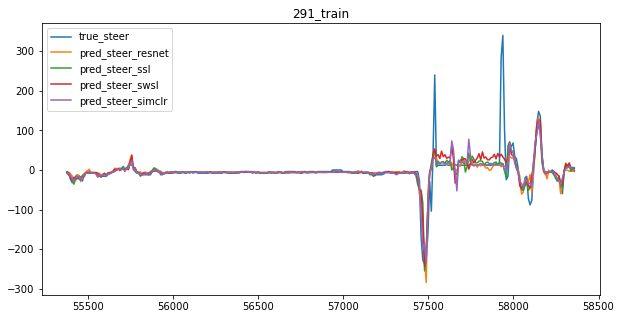

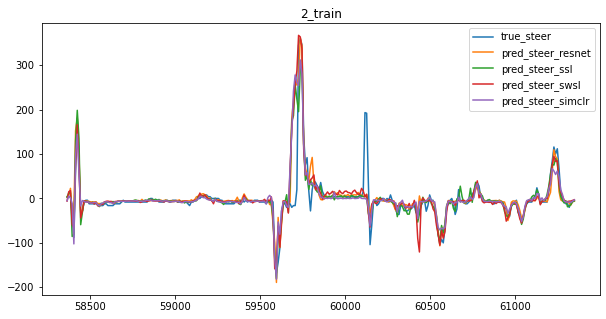

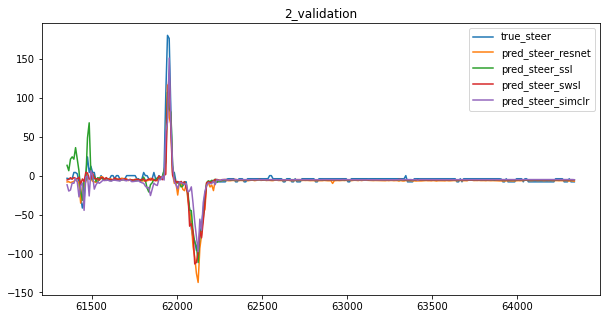

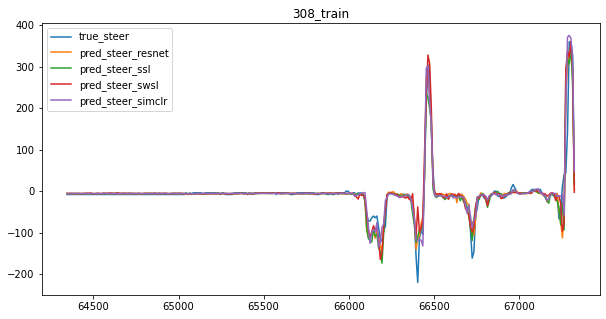

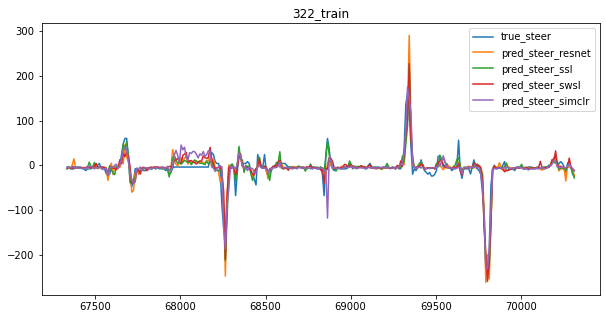

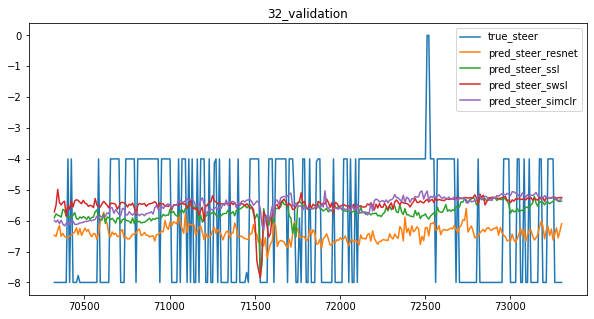

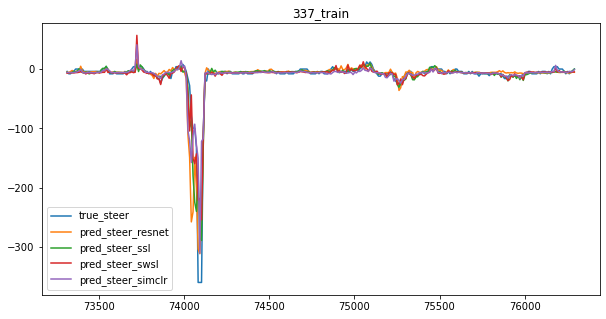

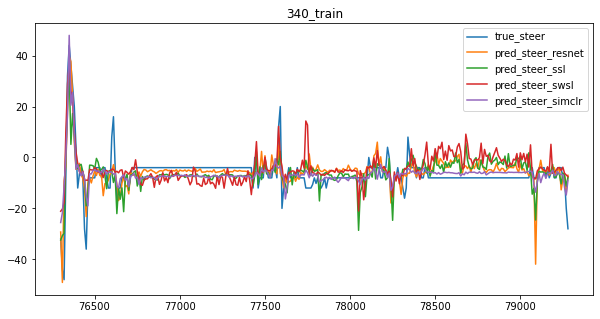

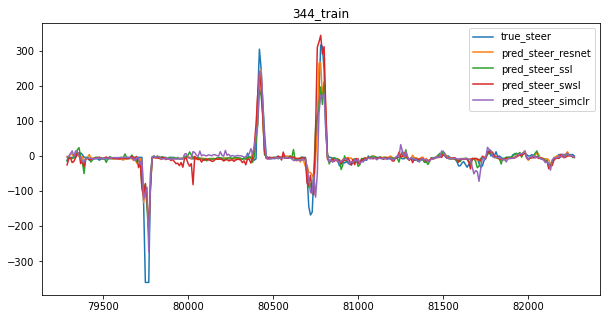

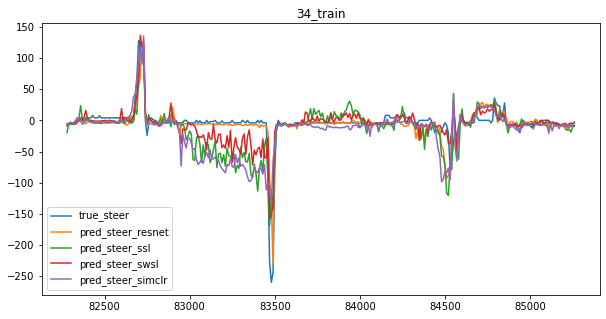

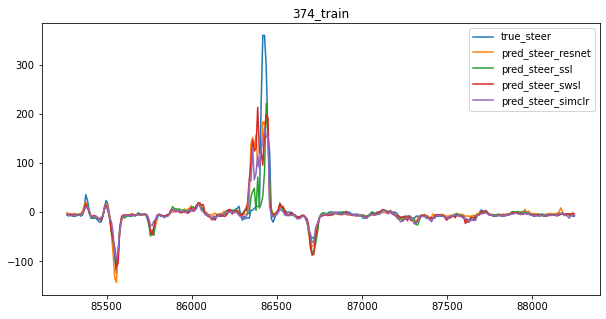

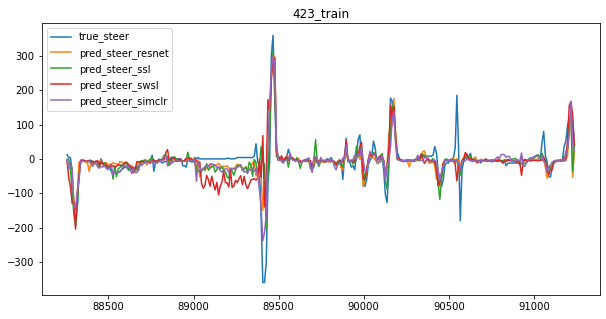

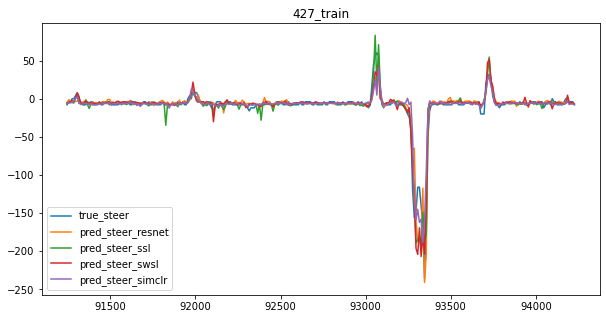

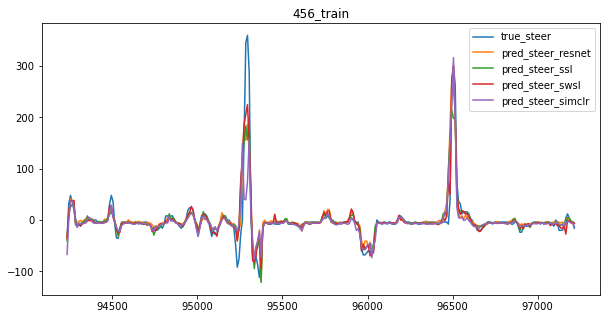

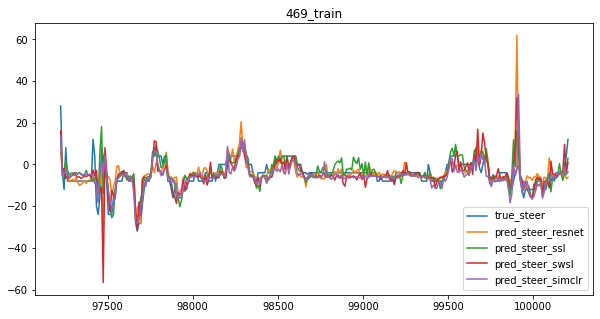

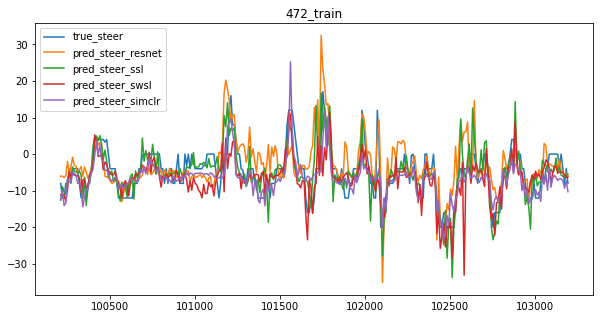

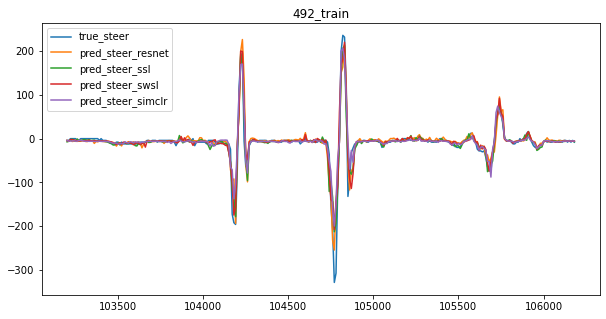

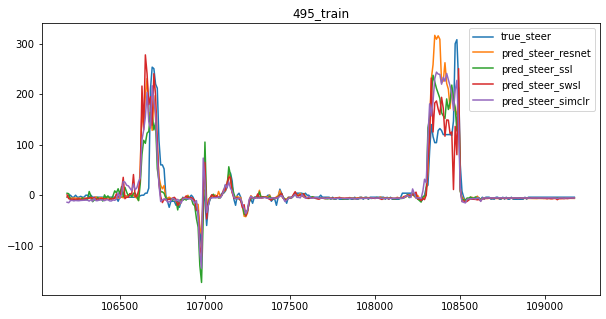

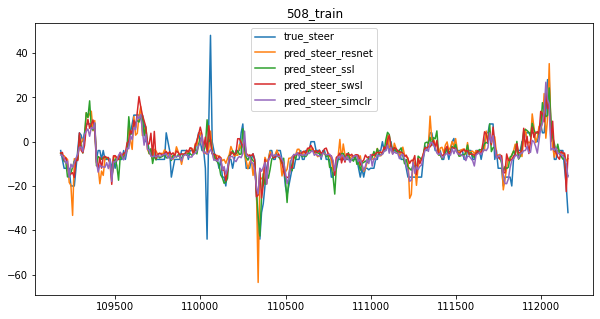

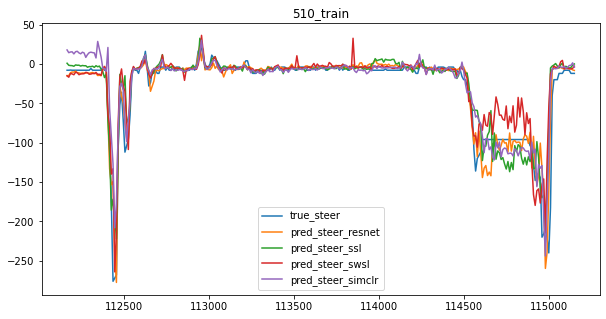

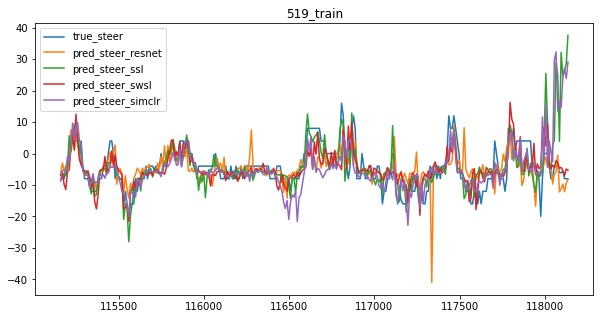

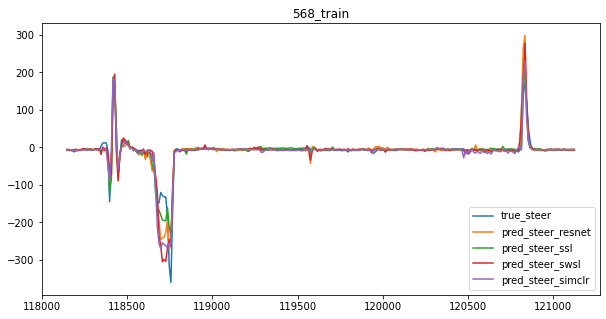

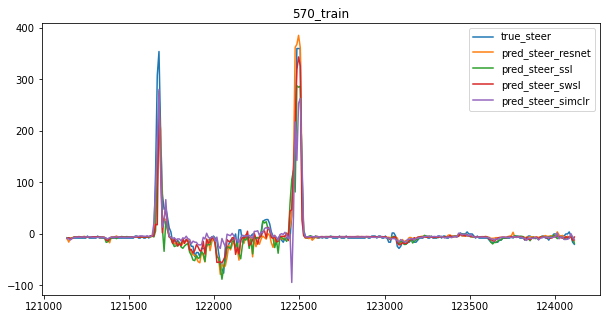

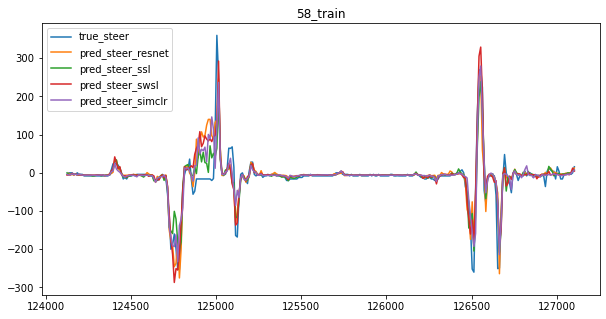

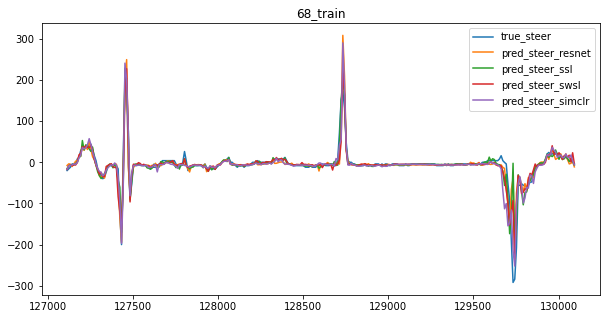

In [128]:
for ch in df.chapter.unique():
    fig, ax = plt.subplots(figsize=(10, 5))
    df[df.chapter == ch][[c for c in df.columns if 'steer' in c]].iloc[::10].plot.line(ax=ax)
    ax.set_title(ch)

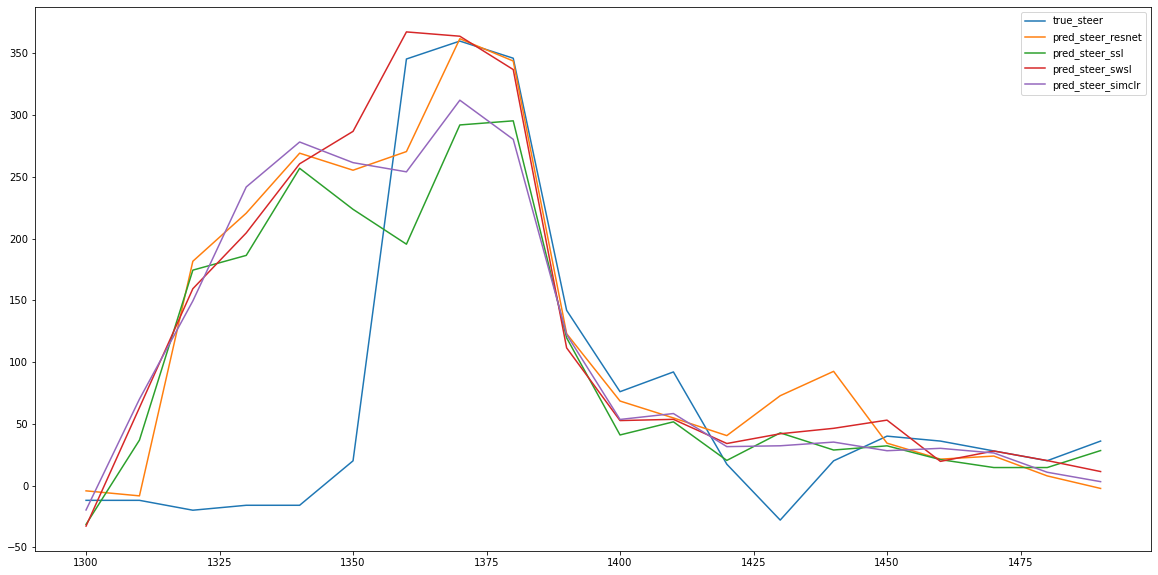

In [87]:
data[[c for c in data.columns if 'steer' in c]].iloc[1300:1500:10].plot.line(figsize=(20, 10))